# Tutorial 1: Introduction to Singular Spectrum Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ADSCIAN/ssalib/blob/main/notebooks/01_basic_ssa_introduction.ipynb)

Singular Spectrum Analysis (SSA) is an effective nonparametric method for time series decomposition.

## Use Cases
SSA can be used to:
1. Separate deterministic components from noise within a time series;
2. Fill gaps in the time series using its correlation structure;
3. Assess the significance of individual components.

This tutorial will primarily focus on separating deterministic components from noise (case 1).

## Basic Principles
The primary concept in SSA involves creating a trajectory or a covariance matrix to capture dependencies between time series lags, followed by decomposition using Singular Value Decomposition (SVD). SVD is a linear matrix decomposition technique, often underlying Principal Component Analysis (PCA), that extracts orthogonal components (vectors) ordered by descending variance (eigen or singular values).

Components with similar patterns can be grouped together. Groups are then reconstructed into a matrix and converted back into a clean time series.

## Import Modules

We import `matplotlib` for plotting, and from the `ssalib` module, we import the
`SingularSpectrumAnalysis` class, renaming it to `SSA` for brevity. We also import 
the `load_sst` function to access an included dataset of Sea Surface Temperature (SST).


In [1]:
#!pip install git+https://github.com/ADSCIAN/ssalib.git # <-- Uncomment to install if needed
import matplotlib.pyplot as plt

from ssalib import SingularSpectrumAnalysis
from ssalib.datasets import load_sst

## Data

* We can access the documentation of the `load_sst` function with the built-in `help` method,
* We run the function to retrieve a time series `sst` as a [pandas.Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) object.
* The data contain 504 monthly mean observations of sea surface temperature in °C from 1982-01-01
to 2023-12-31.
* We plot the data using the series [`plot`](https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.html) method.

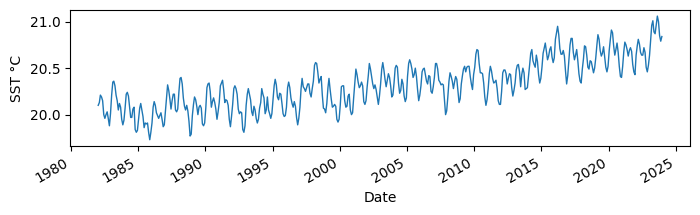

In [2]:
# help(load_sst) #  <- uncomment to have a description
sst = load_sst()
ax = sst.plot(figsize=(8, 2), ylabel='SST °C', lw=1.)

## SSA Initialization

We now have the `ts` time series for the analysis.

* We instantiate the `SingularSpectrumAnalysis` class with the `sst` time series object, keeping the other arguments as default (use `help` for details).
* After the initialization, the matrix to be decomposed has been constructed by default using the Broomhead &
King (1986) trajectory matrix approach (hereafter, 'BK'). We can access the trajectory matrix to be decomposed with the `svd_matrix` attribute.
* We can also plot it with the `plot` method, while passing `kind='matrix'`.

**Details**
The 'BK' trajectory matrix $\mathbf{X}$ is mathematically constructed based on a time series $X_t = \{x_1, x_2, \dots, x_N\}$
and the `window` parameter $L$ such that it has a dimension $L \times K$.
$$
\mathbf{X} = \begin{bmatrix} 
    x_1 & x_2 & x_3 & \dots & x_K \\
    x_2 & x_3 & x_4 & \dots & x_{K+1} \\
    x_3 & x_4 & x_5 & \dots & x_{K+2} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_L &  x_{L+1} & x_{L+2} & \dots & x_{N} 
    \end{bmatrix}
$$

* The default `window` parameter, or $L$, is equal to the half-length of the time series (i.e., `len(sst)//2`).
* $\mathbf{X}$ has all its anti-diagonal elements equal, a property that can be used to reconstruct the original timeseries from the matrix.





(252, 253)

# SingularSpectrumAnalysis
timeseries: Series, n=504, mean=20.32, std=0.26
svd_matrix_kind: bk_trajectory (252, 253)
window: 252
standardize: True
svd_solver: numpy_standard
status: Initialized
n_components: None
groups: None


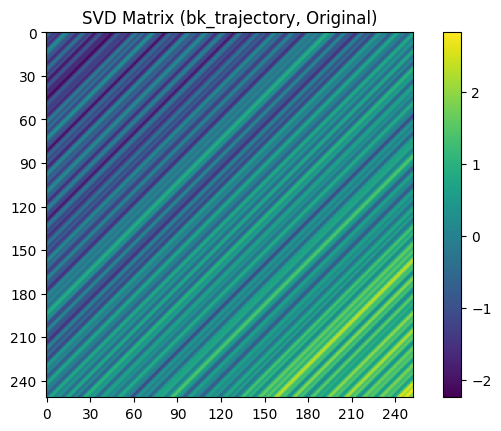

In [3]:
# help(SingularSpectrumAnalysis) # <- Uncomment to get help
ssa = SingularSpectrumAnalysis(sst)
print(ssa.svd_matrix.shape)
print(ssa)
fig, ax = ssa.plot(kind='matrix')

* The values within the matrix range mainly between -2 and 2.
By default, the matrix is constructed using the z-standardized timeseries resulting from the preprocessing.
* We can view both series while calling the `plot` method with `kind='timeseries'`.

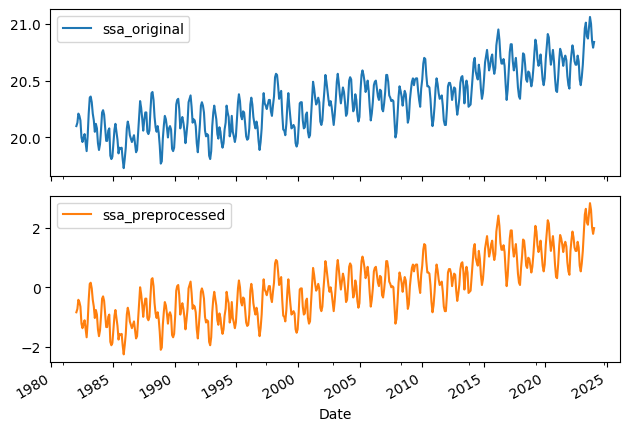

In [4]:
fig, axes = ssa.plot(kind='timeseries', subplots=True)

## SSA Decomposition

* We can now decompose the matrix by calling the `decompose` method.
* After, we can access the eigentriples (u, s, vt) with the `decomposition_results` attribute.

**Details** The Singular Value Decomposition (SVD) of a matrix $\mathbf{X}$ of shape $L \times K$ can be represented as:

$$
\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
$$

where:

- $\mathbf{U} \in \mathbb{R}^{L \times L}$ is an orthogonal matrix whose columns are called the **left singular vectors** of $\mathbf{X}$.
- $\mathbf{\Sigma} \in \mathbb{R}^{L \times K}$ is a diagonal matrix containing the **singular values** of $\mathbf{X}$ along its diagonal.
- $\mathbf{V} \in \mathbb{R}^{K \times K}$ is an orthogonal matrix whose columns are called the **right singular vectors** of $\mathbf{X}$.
- $\mathbf{V}^T$ is the transpose of $\mathbf{V}$.

Alternatively, SVD can be described in the sum form as:

$$
\mathbf{X} = \sum_{i=1}^{r} \sigma_i \mathbf{u}_i \mathbf{v}_i^T
$$

where:

- $r$ is the **rank** of the matrix $\mathbf{X}$.
- $\sigma_i$ are the **singular values**, with $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0$.
- $\mathbf{u}_i \in \mathbb{R}^L$ and $\mathbf{v}_i \in \mathbb{R}^K$ are the **left** and **right singular vectors** corresponding to $\sigma_i$.

In this representation, SVD expresses the matrix $\mathbf{X}$ as a weighted sum of rank-1 matrices formed by the outer product of the left and right singular vectors.

We refer to $\mathbf{u}_i$, $\sigma_i$, $\mathbf{v}_i^T$ as the ith eigentriple. $\mathbf{X}_i = \sigma_i \mathbf{u}_i \mathbf{v}_i^T$ is also referred to as an elementary matrix.

In [5]:
ssa.decompose()
print(ssa)
u, s, vt = ssa.decomposition_results
print('Eigentriple dimension:', [i.shape for i in ssa.decomposition_results])


# SingularSpectrumAnalysis
timeseries: Series, n=504, mean=20.32, std=0.26
svd_matrix_kind: bk_trajectory (252, 253)
window: 252
standardize: True
svd_solver: numpy_standard
status: Decomposed
n_components: 252
groups: None
Eigentriple dimension: [(252, 252), (252,), (253, 253)]


## SSA Components Selection

* The next step involves selecting meaningful groups of components for the reconstruction step.
* We visualize the singular values with the `plot` method, limited to the first 50 components.
* Singular values are by default presented in decreasing order of captured variance, meaning the first components capture the most part of the signal dynamics.

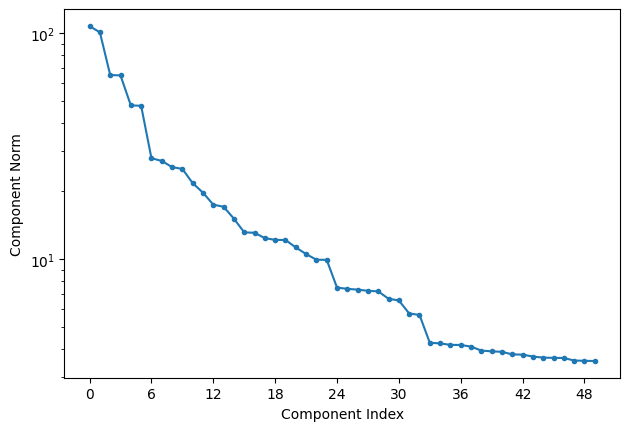

In [6]:
fig, ax = ssa.plot(n_components=50, marker='.')  # kind='values' by default

We can observe 
- a two-by-two component staircase pattern for the first 6 components;
- then a regular decrease in component norms until the 25th components
- another decrease until we reach another rupture point before the noise floor around the 33rd component.

**Note**: In Python, the first element of an array has the index 0.

In general, the first six components are well separated from the rest of the signal, that is less structured. Very often, two close singular values are associated with the quadrature components of clean cyclic patterns (i.e., sine and cosine) We can also plot the values, ordered by the frequency of the associated components, by passing the argument `rank_by='freq'` to the `plot` method. We will also highlight the annual frequency (1/12) and semi-annual (2/12) to increase legibility.

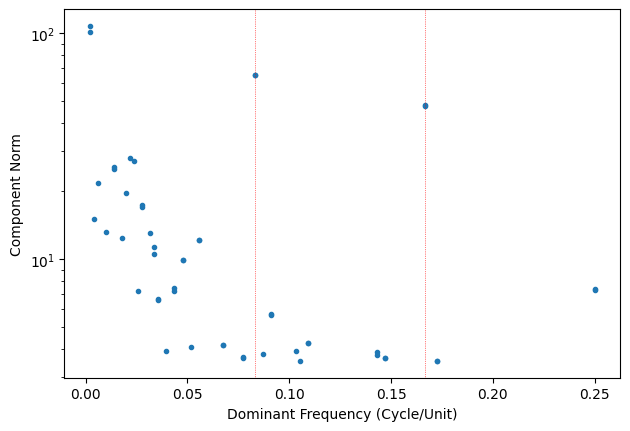

In [7]:
fig, ax = ssa.plot(rank_by='freq', n_components=50, marker='.', ls='none')
_ = ax.axvline(1 / 12, color='r', ls=':', lw=.5)  # annual cycle
_ = ax.axvline(2 / 12, color='r', ls=':', lw=.5)  # semi-annual cycle frequency

In this case, we observe:
* The main components, [0,1] in the previous figure, have a very low frequency, i.e., they correspond to the trend of the signal.
* The components [2,3] are perfectly overlapping on the frequency of the annual cycle.
* The components [4,5] are perfectly overlapping on the semi-annual frequency.

Hence, we have likely identify the main trend and cyclic behavior in our signal.

## SSA Reconstruction

* For the reconstruction, a matrix can be reconstructed for any selection of components, based on the SVD additive formula.

Given a group of indices $I = {2,3}$ for instance, we can reconstruct a matrix capturing the seasonal behavior with:
$$
\mathbf{X}_I = \sum_{i \in I} \sigma_i \mathbf{u}_i \mathbf{v}_i^T
$$

* You can check it with the `plot` methods and the `kind` argument set to matrix, which also enable to visualize reconstructed matrix based on selected indices.


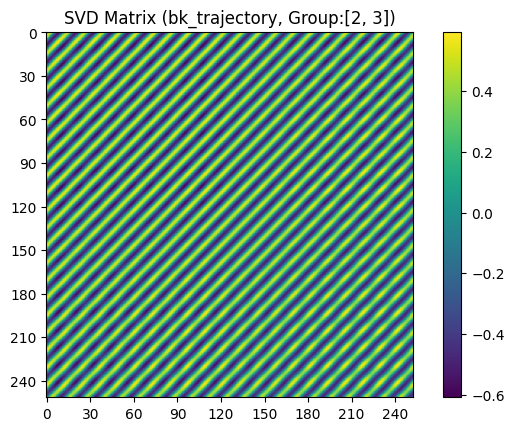

In [8]:
fig, ax = ssa.plot(kind='matrix', indices=[2, 3])

We indeed observe a perfectly regular pattern corresponding to the annual cycle associated with the components [2,3].

However, the matrix should still be transformed back into a timeseries component, which can be done by averaging the anti-diagonals of the reconstructed trajectory matrix. 

The `ssalib` API let you recompose signals in a very flexible way using the getitem api with integers, list of integers, or slicing referring to the component indices. Hence, we can recover the signal associated with our 6 main components:

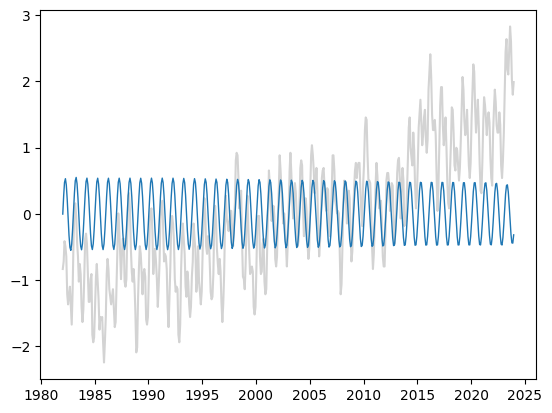

In [9]:
_ = plt.plot(ssa['ssa_preprocessed'], color='lightgrey')
_ = plt.plot(ssa[[2,3]], lw=1.)  # reconstructed annual cycle

Alternatively, we could use a more formal approach using the `reconstruct` method while passing a dictionary with the desired groups.

In the following example, we reconstruct the same groups as before.

In [10]:
groups = {
    'Trend': [0, 1],
    '1Y_cycle': [2, 3],
    '6M_cycle': [4, 5],
    'Denoised_signal': [0, 1, 2, 3, 4, 5]
}
ssa.reconstruct(groups)

Reconstructed groups contain duplicate indices: [0, 1, 2, 3, 4, 5]


SingularSpectrumAnalysis(timeseries=<Series shape=(504,)>, window=252, svd_matrix='SSAMatrixType.BK_TRAJECTORY', svd_solver='numpy_standard', standardize=True)

We got a warning because we reconstructed different groups using multiple time the same indices, which means that we should not sum the signal we have reconstructed. We can now also retrieve a component by its name:

Date
1982-01-15   -0.993569
1982-02-15   -1.006196
1982-03-15   -1.024155
1982-04-15   -1.045457
1982-05-15   -1.065604
Name: Trend, dtype: float64


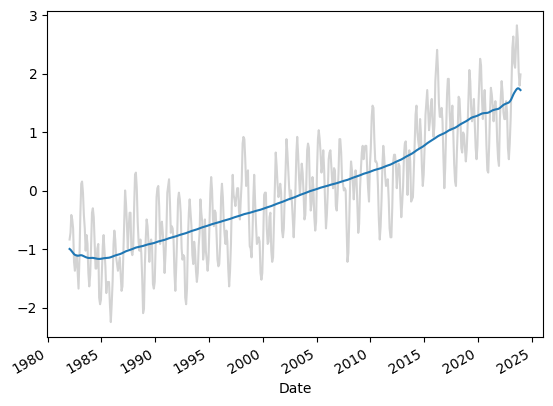

In [11]:
ax = ssa['ssa_preprocessed'].plot(color='lightgrey')
_ = ssa['Trend'].plot(ax=ax)  # plot trend
print(ssa['Trend'].head(5))  # print first 5 trend values

You can also easily plot the components using the `plot` method with `kind='timeseries`, and select which one to include using the `include` argument. This approach also has the advantage of rescaling the components to its original standard deviation and mean if `rescale=True`.

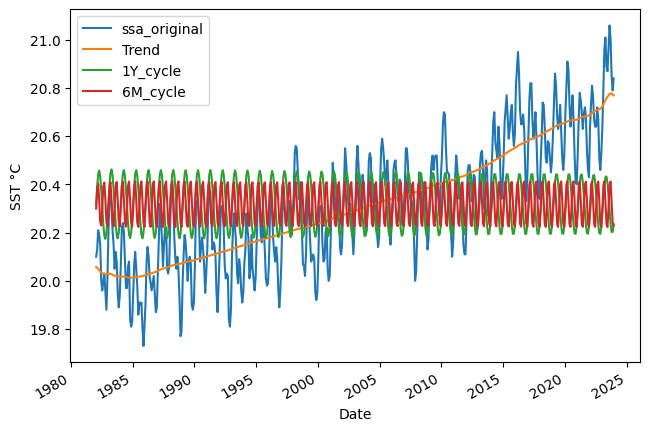

In [12]:
fig, ax = ssa.plot('timeseries',
                   include=['ssa_original', 'Trend', '1Y_cycle', '6M_cycle'],
                   rescale=True)
_ = ax.set_ylabel('SST °C')

Using the `reconstruct` method also enabled the retrieval of components by their names. 

Date
1982-01-15   -0.993569
1982-02-15   -1.006196
1982-03-15   -1.024155
1982-04-15   -1.045457
1982-05-15   -1.065604
                ...   
2023-08-15    1.743738
2023-09-15    1.754162
2023-10-15    1.751717
2023-11-15    1.739077
2023-12-15    1.723549
Name: Trend, Length: 504, dtype: float64


<Axes: xlabel='Date'>

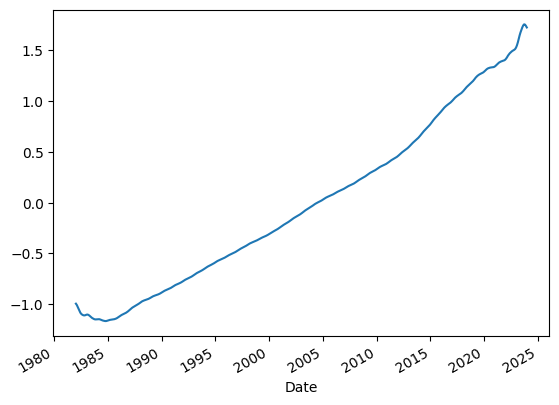

In [13]:
print(ssa['Trend'])
ssa['Trend'].plot()

If one need to rescale the reconstructed components manually, it is possible to access the original mean and standard deviation with the `mean_` and `std_` arguments.

In [14]:
ssa.mean_, ssa.std_

(np.float64(20.318174603174604), np.float64(0.2620861084527186))

Finally, SSALib makes it possible to export all reconstructed components using the `to_frame` method. The arguments can be used to include or exclude components, and specify whether rescaling is required.

In [15]:
#help(ssa.to_frame) # <- uncomment to get help
ssa.to_frame()

,ssa_original,ssa_preprocessed,ssa_reconstructed,ssa_residuals,Trend,1Y_cycle,6M_cycle,Denoised_signal
Date,,,,,,,,
1982-01-15,20.10,-0.832454,-0.832454,0.234527,-0.993569,-0.002916,-0.070495,-1.066980
1982-02-15,20.13,-0.717988,-0.717988,-0.247002,-1.006196,0.277556,0.257654,-0.470985
1982-03-15,20.21,-0.412745,-0.412745,-0.187141,-1.024155,0.474260,0.324292,-0.225603
1982-04-15,20.19,-0.489055,-0.489055,-0.032882,-1.045457,0.531703,0.057580,-0.456173
1982-05-15,20.15,-0.641677,-0.641677,0.263030,-1.065604,0.436432,-0.275535,-0.904707
...,...,...,...,...,...,...,...,...
2023-08-15,21.06,2.830464,2.830464,0.878015,1.743738,-0.099800,0.308511,1.952449
2023-09-15,21.00,2.601532,2.601532,0.799230,1.754162,-0.310368,0.358509,1.802302
2023-10-15,20.85,2.029201,2.029201,0.664881,1.751717,-0.437595,0.050197,1.364320
